# **Importing the Libraries**

In [ ]:
import pandas as pd    # to load dataset
import numpy as np  
import matplotlib.pyplot as plt   
from sklearn.model_selection import train_test_split       # for splitting dataset
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re
import io
from wordcloud import WordCloud, STOPWORDS
from googleapiclient.http import MediaIoBaseDownload
from PIL import Image
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_validate
from nltk.tokenize import WordPunctTokenizer

In [ ]:
stopwords = set(ENGLISH_STOP_WORDS)
stopwords.update(['br'])


# **Importing Data From Google Drive**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# **Importing DataSet**

In [ ]:
#link_dataset = 'https://drive.google.com/file/id=18VEqRzF6o7v1fr-wPp_Q9w8G06pm1Em2' # The shareable link for Train dataset
link_dataset = 'https://drive.google.com/file/id=1DlgocnYFNTr9h50HelpO7jvRxgZ8GsMd' # The shareable link for COVID-19 Vaccine dataset
fluff, id_train = link_dataset.split('=')
downloaded = drive.CreateFile({'id':id_train}) 
#downloaded.GetContentFile('IMDBDataset.csv')  
downloaded.GetContentFile('COV.csv')  


# **Data Preprocessing**

In [ ]:

def load_dataset():
    df = pd.read_csv('COV.csv', encoding='cp1252')
    df.rename(columns={'comment': 'review'}, inplace=True)
    #df = pd.read_csv('IMDBDataset.csv')
    x_data = df['review']       # Comments/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS COMMENTS
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in ENGLISH_STOP_WORDS ])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case
    
    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

#**Data Visualisation**



In [ ]:
df = pd.read_csv('COV.csv', encoding='cp1252')
df.rename(columns={'comment': 'review'}, inplace=True)
import plotly.express as px
fig = px.pie(df, names='source', title ='Pie chart of different Sources')
fig.show()

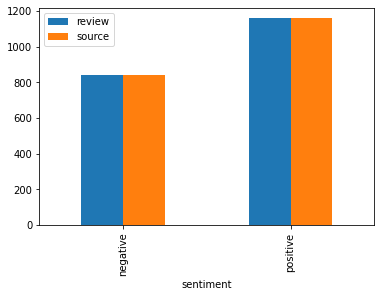

In [ ]:
#df = pd.read_csv('IMDBDataset.csv')
df1 = df
df1 = pd.read_csv('COV.csv',encoding='cp1252')
df1 = df1.drop(['source'], axis=1)
df.groupby('sentiment').count().plot(kind='bar')
#df.groupby('sentiment').count().plot(kind='bar')

Plot review/comment/opinion (RCO) length

(0.0, 2500.0)

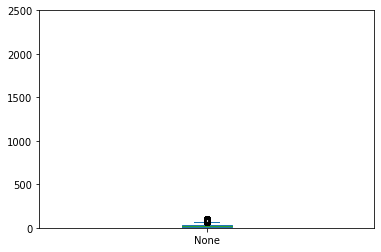

In [ ]:
# Calculate RCO lengths
rco_len = pd.Series([len(rco.split()) for rco in df['review']])
ax = rco_len.plot.box()
plt.ylim([0, 2500])

Plotting the distribution of text length for positive sentiment RCO



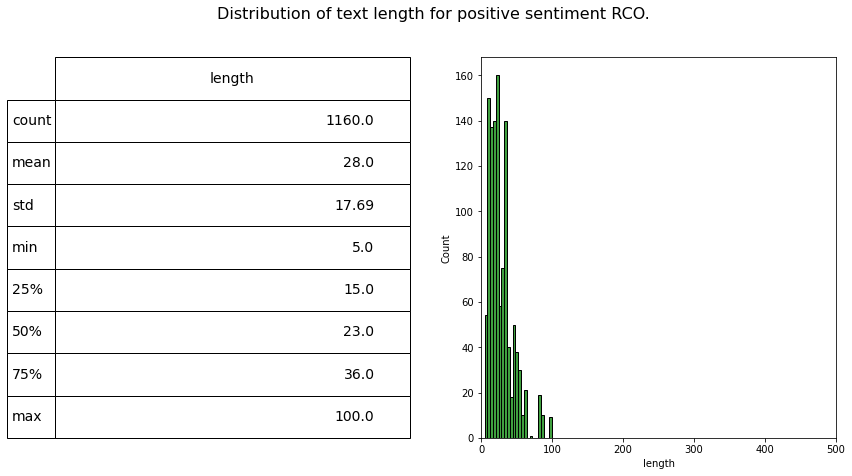

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']=='positive']['length'], ax=ax1,color='green')
plt.xlim([0, 500])
describe = df.length[df.sentiment=='positive'].describe().to_frame().round(2)


ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment RCO.', fontsize=16)
plt.show()


Plotting the distribution of text length for negative sentiment RCO

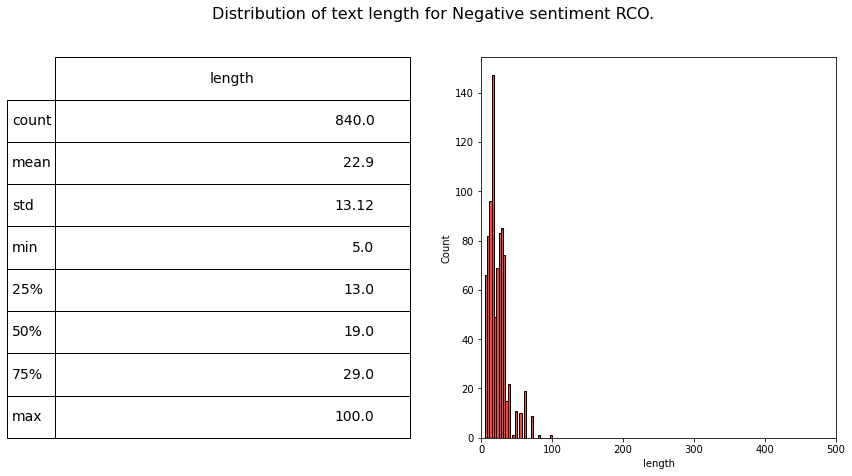

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']=='negative']['length'], ax=ax1,color='red')
plt.xlim([0, 500])
describe = df.length[df.sentiment=='negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment RCO.', fontsize=16)

plt.show()

Plotting the Pie chart of the percentage of different sentiments of all the RCO



In [ ]:
import plotly.express as px
fig = px.pie(df, names='sentiment', title ='Pie chart of different sentiments of RCO')
fig.show()

Visualizing data into wordclouds

In [ ]:
def google_authenticate():
  # Authenticate first so the Google Drive library can detect your credentials.
  from google.colab import auth
  auth.authenticate_user()

  from googleapiclient.discovery import build
  drive_service = build('drive', 'v3')
  return drive_service

drive_service = google_authenticate()

def read_file(file_id):  
  file_id = file_id
  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    _, done = downloader.next_chunk()

  downloaded.seek(0)
  return downloaded

In [ ]:
def create_wordcloud(df, sentiment, stopwords, imgMask):
    combined_rco = " ".join([tweet for tweet in df[df.sentiment==sentiment]['review']])

    # generating wordcloud
    wc = WordCloud(background_color='black', mask=imgMask, stopwords=stopwords, max_words=50)
    wc.generate(combined_rco)

    # plot the word cloud
    plt.figure(figsize=(5,3), dpi=250)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
image_file = read_file("1BY7yMIqQut4Gw7idiIyEH3TKB91CD5fH")

# create mask
mask = np.array(Image.open(image_file))

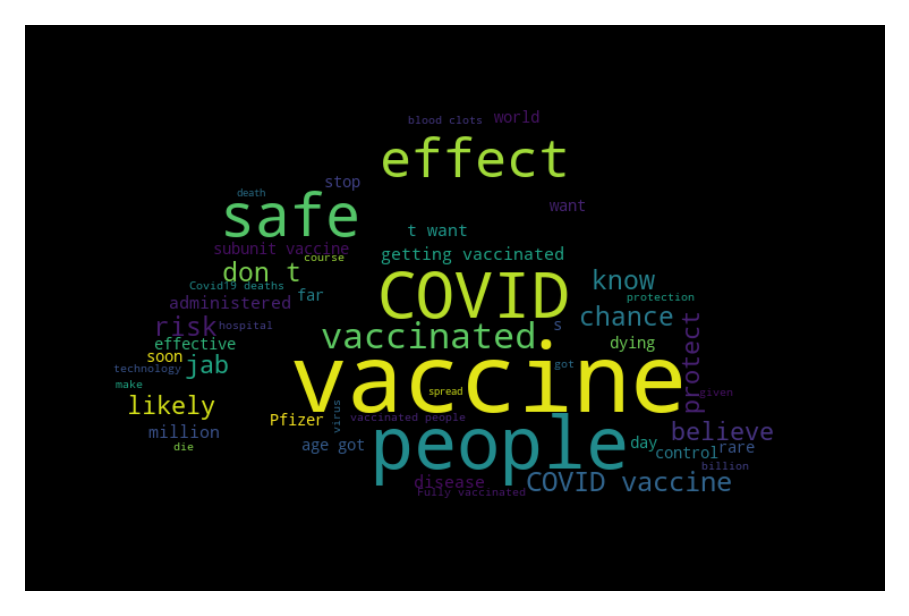

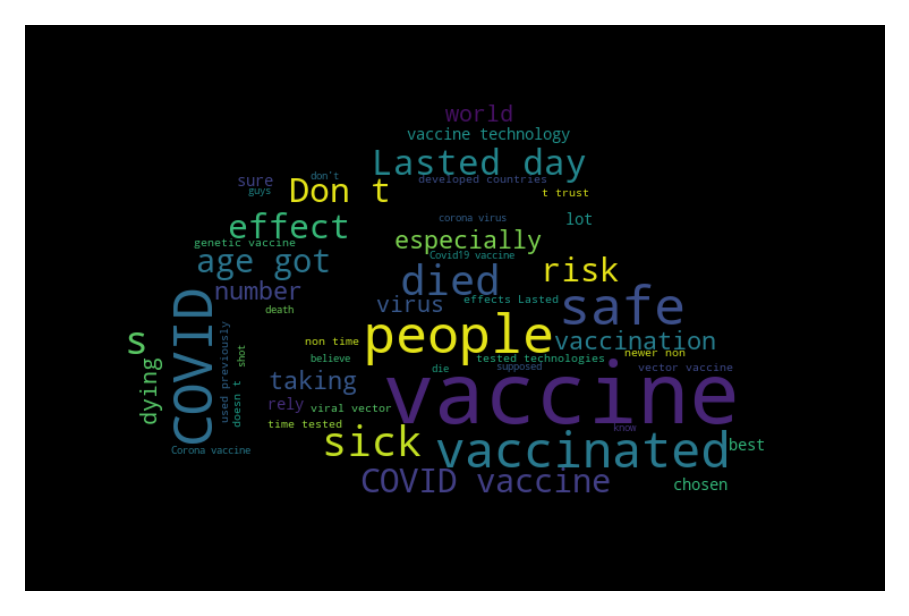

In [ ]:
if __name__ == "__main__":
    create_wordcloud(df, "positive", stopwords, mask)
    create_wordcloud(df, "negative", stopwords, mask)

#Spliting Dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state=0) #data for LSTM
train_data, test_data = train_test_split(df, test_size = 0.2, random_state=0) 
test_sentiment = test_data.sentiment

# **Process Data For Bag of Words(BoW) and SVD**


In [ ]:
def process_data(train_data, SVD):
    # bag of words 
    count_vectorizer = CountVectorizer( stop_words=stopwords)
    X = count_vectorizer.fit_transform(train_data['review'])

    if SVD:
        print("")
        print('Using Singular Value Decomposition(SVD)...')
        svd = TruncatedSVD(n_components=100, random_state=1)
        X = svd.fit_transform(X)
    else:
        print('Using Bag of Words(BOW)...')

    # Normalization
    normalizer = preprocessing.Normalizer()
    X = normalizer.fit_transform(X)

    # setting the labels array
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(train_data["sentiment"])

    return X, y


# **Support Vector Machine (SVM)**

In [ ]:
def SVM(train_data, SVD):
    X, y = process_data(train_data, SVD)

    # SVM classifier
    clf = svm.SVC(decision_function_shape='ovo')
    # 5 fold cross validation
    print("Attempting 5-fold cross validation...")

    scoring = {
        'acc': 'accuracy',
        'prec_macro': 'precision_macro',
        'rec_macro': 'recall_macro',
        'f1_macro': 'f1_macro'

    }
    scores = cross_validate(clf, X, y, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1)
    print('Accuracy:', np.mean(scores['test_acc']), scores['test_acc'])
    print('Precision:', np.mean(scores['test_prec_macro']), scores['test_prec_macro'])
    print('Recall:', np.mean(scores['test_rec_macro']), scores['test_rec_macro'])
    print('F-Measure:', np.mean(scores['test_f1_macro']), scores['test_f1_macro'])

# **Random Forest**

In [ ]:
def random_forest(train_data, SVD):
    X, y = process_data(train_data, SVD)

    # Random Forest classifier
    clf = RandomForestClassifier(n_estimators=50, max_features='auto')

    # 5 fold cross validation
    print("Attempting 5-fold cross validation...")

    scoring = {
        'acc': 'accuracy',
        'prec_macro': 'precision_macro',
        'rec_macro': 'recall_macro',
        'f1_macro': 'f1_macro'

    }
    scores = cross_validate(clf, X, y, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1)
    print('Accuracy:', np.mean(scores['test_acc']), scores['test_acc'])
    print('Precision:', np.mean(scores['test_prec_macro']), scores['test_prec_macro'])
    print('Recall:', np.mean(scores['test_rec_macro']), scores['test_rec_macro'])
    print('F-Measure:', np.mean(scores['test_f1_macro']), scores['test_f1_macro'])

# **Linear Support Vector Classification (SVC)**

In [ ]:
def LSVC():

    # train SVM
    clf = LinearSVC(C=1.15, loss='hinge')
    clf.fit(X, y)
    
    return clf.predict(X_test)

def SVM_cross_val():

    # SVM classifier
    clf = LinearSVC(C=1.15, loss='hinge')
    # 5 fold cross validation
    print("Attempting 5-fold cross validation...")

    scoring = {
        'acc': 'accuracy',
        'prec_macro': 'precision_macro',
        'rec_macro': 'recall_macro',
        'f1_macro': 'f1_macro'

    }
    scores = cross_validate(clf, X, y, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1)
    print('Accuracy:', np.mean(scores['test_acc']), scores['test_acc'])
    print('Precision:', np.mean(scores['test_prec_macro']), scores['test_prec_macro'])
    print('Recall:', np.mean(scores['test_rec_macro']), scores['test_rec_macro'])
    print('F-Measure:', np.mean(scores['test_f1_macro']), scores['test_f1_macro'])


In [ ]:
if __name__ == "__main__":
    print("Applying Support Vector Machines(SVM) Classification Method")
    #SVM(train_data, SVD=False) # SVM-BoW
    #SVM(train_data, SVD=True)  # SVM-SVD
    print("\n\n")
    print("Applying Random Forest Classification Method")
    random_forest(train_data, SVD=False) # Random Forest-BoW
    random_forest(train_data, SVD=True)  # Random Forest-SVD
    print("\n\n")
    print("Applying SVM-LSVC ()...")
    # process data for prediction
    tfidf_vectorizer = TfidfVectorizer( stop_words=stopwords)
    X = tfidf_vectorizer.fit_transform( train_data['review'])
    X_test = tfidf_vectorizer.transform(test_data['review'])

    # setting the labels array
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(train_data["sentiment"])
    SVM_cross_val()

Applying Support Vector Machines(SVM) Classification Method



Applying Random Forest Classification Method
Using Bag of Words(BOW)...
Attempting 5-fold cross validation...
Accuracy: 0.9268750000000001 [0.909375 0.909375 0.93125  0.934375 0.95    ]
Precision: 0.9252515605403498 [0.90760761 0.90742913 0.92857143 0.93197265 0.95067698]
Recall: 0.9272058823529411 [0.90680946 0.91640026 0.93158568 0.93430307 0.94693095]
F-Measure: 0.9254887397187638 [0.90719907 0.90862454 0.92992515 0.93305106 0.94864388]

Using Singular Value Decomposition(SVD)...
Attempting 5-fold cross validation...
Accuracy: 0.9268750000000001 [0.909375 0.909375 0.93125  0.934375 0.95    ]
Precision: 0.9252515605403498 [0.90760761 0.90742913 0.92857143 0.93197265 0.95067698]
Recall: 0.9272058823529411 [0.90680946 0.91640026 0.93158568 0.93430307 0.94693095]
F-Measure: 0.9254887397187638 [0.90719907 0.90862454 0.92992515 0.93305106 0.94864388]



Applying SVM-LSVC ()...
Attempting 5-fold cross validation...
Accuracy: 0.

**Test Accuracy using LSVC**

In [ ]:
y_pred_LSVC = LSVC()  # Support Vector Machine Linear Support Vector Classification
# ENCODE SENTIMENT -> 0 & 1
test_sentiment = test_sentiment.replace('positive', 1)
test_sentiment = test_sentiment.replace('negative', 0)
true1 = 0
for i, y in enumerate(test_sentiment):
    if y == y_pred_LSVC[i]:
        true1 += 1

print('Correct Prediction: {}'.format(true1))
print('Wrong Prediction: {}'.format(len(y_pred_LSVC) - true1))
print('Test Accuracy: {}'.format(true1/len(y_pred_LSVC)*100))

Correct Prediction: 369
Wrong Prediction: 31
Test Accuracy: 92.25


#**LSTM Preprocessing**

In [ ]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [ ]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')
total_words = len(token.word_index) + 1   # add 1 because of 0 padding


#**LSTM**

In [ ]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

modellstm = Sequential()
modellstm.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
modellstm.add(LSTM(LSTM_OUT))
modellstm.add(Dense(1, activation='sigmoid'))
modellstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(modellstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 32)            28448     
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 53,345
Trainable params: 53,345
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
modellstm.fit(x_train, y_train, batch_size = 128, epochs = 4, callbacks=[checkpoint])

Epoch 1/4
12/13 [==========================>...] - ETA: 0s - loss: 0.6870 - accuracy: 0.5723
Epoch 1: accuracy improved from -inf to 0.57313, saving model to models/LSTM.h5
13/13 [==============================] - 3s 19ms/step - loss: 0.6864 - accuracy: 0.5731
Epoch 2/4
11/13 [========================>.....] - ETA: 0s - loss: 0.6499 - accuracy: 0.5696
Epoch 2: accuracy improved from 0.57313 to 0.57938, saving model to models/LSTM.h5
13/13 [==============================] - 0s 19ms/step - loss: 0.6382 - accuracy: 0.5794
Epoch 3/4
11/13 [========================>.....] - ETA: 0s - loss: 0.4169 - accuracy: 0.8217
Epoch 3: accuracy improved from 0.57938 to 0.83000, saving model to models/LSTM.h5
13/13 [==============================] - 0s 19ms/step - loss: 0.4204 - accuracy: 0.8300
Epoch 4/4
11/13 [========================>.....] - ETA: 0s - loss: 0.3126 - accuracy: 0.9098
Epoch 4: accuracy improved from 0.83000 to 0.91062, saving model to models/LSTM.h5
13/13 [============================

**Test Accuracy using LSTM**

In [ ]:
score, acc_lstm = modellstm.evaluate(x_test, y_test, batch_size=32)
print("Score: ",score)
print("Test Accuracy: ",acc_lstm)

13/13 [==============================] - 1s 3ms/step - loss: 0.3118 - accuracy: 0.9050
Score:  0.3117673397064209
Test Accuracy:  0.9049999713897705


Model Confusion Matrix

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



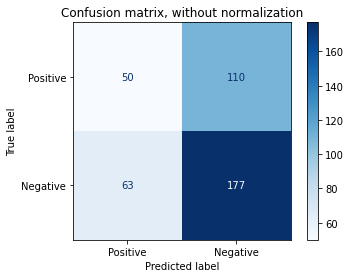

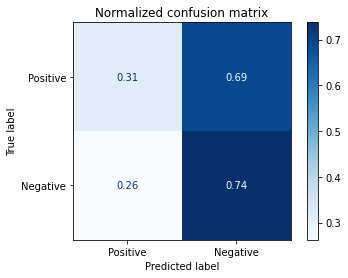

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# import some data to play with

# Split the data into a training set and a test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
target_names = ['Positive', 'Negative']
class_names = target_names
# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = LinearSVC(C=1.15, loss='hinge').fit(x_train, y_train)
np.set_printoptions(precision=2)

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)


plt.show()

# **Generate CSV file for testing result using best model**

In [ ]:
best_pred = 0
if true1/len(y_pred_LSVC)*100>= acc_lstm*100:
    best_pred = y_pred_LSVC
    print(' Best Model: LSVC ')
else:
    best_pred = y_pred_LSTM
    print('Best Model: LSTM')

 Best Model: LSVC 


In [ ]:
prediction = pd.DataFrame(data={"Predicted": le.inverse_transform(best_pred)},  index=test_data['review'] )
prediction.to_csv('predicted_results.csv')
from google.colab import files
files.download('predicted_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Instant Sentiment Check**

In [ ]:
loaded_model = load_model('models/LSTM.h5')
review = str(input('Comment/Review: '))
#Vaccine is safe. It protects life.
#Vaccine is dangerous. It causes death 

# Pre-process input
regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)
print('Cleaned: ', review)

words = review.split(' ')
filtered = [w for w in words if w not in ENGLISH_STOP_WORDS]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]

print('Filtered: ', filtered)

tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
result = loaded_model.predict(tokenize_words)
print('score',result)
if result >= 0.5:
    print('Sentiment: positive')
else:
    print('Sentiment: negative')

Comment/Review: Vaccine is safe
Cleaned:  Vaccine is safe
Filtered:  ['vaccine safe']
score [[0.1]]
Sentiment: negative
